---
execute:
  cache: false
  eval: true
  echo: true
  warning: false
jupyter: python3
---

# Hyperparameter Tuning with PyTorch Lightning and User Data Sets  {#sec-light-user-data-1001}

In [1]:
#| echo: false
#| label: 1001_user_data_imports
import numpy as np
import os
from math import inf
import numpy as np
import warnings
if not os.path.exists('./figures'):
    os.makedirs('./figures')
warnings.filterwarnings("ignore")

In this section, we will show how user specfied data can be used for the `PyTorch` Lightning hyperparameter tuning workflow with `spotpython`.

## Loading a User Specified Data Set

Using a user-specified data set is straightforward.

The user simply needs to provide a data set and loads is as a  `spotpython`  `CVSDataset()` class by specifying the path, filename, and target column.

Consider the following example, where the user has a data set stored in the `userData` directory. The data set is stored in a file named `data.csv`. The target column is named `target`. To show the data, it is loaded as a `pandas` data frame and the first 5 rows are displayed. This step is not necessary for the hyperparameter tuning process, but it is useful for understanding the data.

In [2]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import pandas as pd

# from utils import *
# from train import *

import pickle
import matplotlib.pyplot as plt
from torch.utils.data import Dataset

In [3]:
device = 'cpu'
epochs = 2000
seeds = [42, 43, 44, 45, 46, 47, 48, 49, 50, 51]
input_features = ['PI tot V [-]', 'Bereich u2red']
data = pd.read_csv("/Users/bartz/workspace/schu25a_netgen_gecco/data/data_man_tca88.csv")
data["source_file"] = ["tca88"] * len(data)

In [4]:
class ManyToManyDataset(Dataset):
    def __init__(
        self,
        df_list,
        target,
        drop=None,
        dtype=torch.float32,
    ):
        try: 
            self.data = [df.drop(drop, axis=1) for df in df_list]
        except:
            self.data = df_list
        self.target = [torch.tensor(df[target].to_numpy(), dtype=dtype) for df in self.data]
        self.features = [torch.tensor(df.drop([target], axis=1).to_numpy(), dtype=dtype)for df in self.data]

    def __getitem__(self, index):
        x = self.features[index]
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)
    
    
class ManyToOneDataset(Dataset):
    def __init__(
        self,
        df_list,
        target,
        drop=None,
        dtype=torch.float32,
    ):
        try: 
            self.data = [df.drop(drop, axis=1) for df in df_list]
        except:
            self.data = df_list
        self.target = [torch.tensor(df[target].to_numpy()[0], dtype=dtype) for df in self.data]
        self.features = [torch.tensor(df.drop([target], axis=1).to_numpy(), dtype=dtype)for df in self.data]

    def __getitem__(self, index):
        x = self.features[index]
        y = self.target[index]
        return x, y

    def __len__(self):
        return len(self.data)

In [5]:
def load_data(data,
              input_features=['V tot V red [m³/s]'], 
              target= 'PI tot V [-]' ,
              drop = ['Bereich u2red','source_file'],
              group_by='Bereich u2red',
              feature_scaling=None, 
              target_scaling=None, 
              create_dataset=True, 
              dataset_type='many_to_many'):

    if feature_scaling is not None:
        data[input_features] = feature_scaling.fit_transform(data[input_features])
    
    if target_scaling is not None:
        data[target] = target_scaling.fit_transform(data[target])    
    
    if create_dataset == False:
        return data
    else:
        groups = []
        groups_name = []
        data_groups = data.groupby(group_by)

    for name, group in data_groups:
        groups.append(group)
        groups_name.append(name)
    
    if dataset_type == 'many_to_many':
        return ManyToManyDataset(groups, target=target, drop=drop), data
    elif dataset_type == "many_to_one":
        return ManyToOneDataset(groups, target=target, drop=drop), data

In [6]:
kennlinienfelder = data.groupby("source_file")
pred_dict = {}

seeds = [42]
for kennlinienfeld in kennlinienfelder:
    print(f"kennlinienfeld: {kennlinienfeld[0]}")
    data_name = kennlinienfeld[0]
    print(data_name)
    ds, data = ds, _ = load_data(kennlinienfeld[1], 
                                input_features=['PI tot V [-]' ], 
                                target='V tot V red [m³/s]',
                                drop = ['source_file', "Bereich u2red"],
                                group_by="Bereich u2red",
                                # feature_scaling=MinMaxScaler()
                                )
    
    pred_dict[data_name] = {}

    for seed in seeds:
        print(f"seed: {seed}")
        # seed_everything(seed)
        g = torch.Generator()
        g.manual_seed(seed)
        
        pred_dict[data_name][seed] = {}
        pred_dict[data_name][seed]['x'] = []
        pred_dict[data_name][seed]['y_hat'] = []
        pred_dict[data_name][seed]['y'] = []
        pred_dict[data_name][seed]['mape'] = []
        pred_dict[data_name][seed]['rmse'] = []
        
        # Create indices for the split
        indices = list(range(len(ds)))        
        for i in indices:
            print(f"indices: {indices}")
            test_indices = [indices[i]]
            train_indices = [index for index in indices if index != test_indices[0]]
            
            train_dataset = torch.utils.data.Subset(ds, train_indices)
            test_dataset = torch.utils.data.Subset(ds, test_indices)

kennlinienfeld: tca88
tca88
seed: 42
indices: [0, 1, 2, 3, 4, 5, 6, 7, 8]
indices: [0, 1, 2, 3, 4, 5, 6, 7, 8]
indices: [0, 1, 2, 3, 4, 5, 6, 7, 8]
indices: [0, 1, 2, 3, 4, 5, 6, 7, 8]
indices: [0, 1, 2, 3, 4, 5, 6, 7, 8]
indices: [0, 1, 2, 3, 4, 5, 6, 7, 8]
indices: [0, 1, 2, 3, 4, 5, 6, 7, 8]
indices: [0, 1, 2, 3, 4, 5, 6, 7, 8]
indices: [0, 1, 2, 3, 4, 5, 6, 7, 8]


The following step is not necessary for the hyperparameter tuning process, but it is useful for understanding the data. The data set is loaded as a `DataLoader` from `torch.utils.data` to check the data.

In [7]:
#| label: 1001_user_data_dataloader
# Set batch size for DataLoader
batch_size = 1
# Create DataLoader
from torch.utils.data import DataLoader
dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

# Iterate over the data in the DataLoader
for batch in dataloader:
    inputs, targets = batch
    print(f"Batch Size: {inputs.size(0)}")
    print(f"Inputs Shape: {inputs.shape}")
    print(f"Targets Shape: {targets.shape}")
    print("---------------")
    print(f"Inputs: {inputs}")
    print(f"Targets: {targets}")
    break

Batch Size: 1
Inputs Shape: torch.Size([1, 6, 1])
Targets Shape: torch.Size([1, 6])
---------------
Inputs: tensor([[[1.2800],
         [1.4400],
         [1.4700],
         [1.4900],
         [1.5100],
         [1.5400]]])
Targets: tensor([[2.0100, 1.7700, 1.6800, 1.5900, 1.4500, 1.0400]])


In [8]:
from spotpython.data.lightdatamodule import LightDataModule
data_module = LightDataModule(dataset=train_dataset, batch_size=5, test_size=0.5)
data_module.setup()
print(f"Training set size: {len(data_module.data_train)}")

Training set size: 2


In [9]:
len(train_dataset), len(test_dataset)

(8, 1)

In [10]:
from spotpython.hyperdict.light_hyper_dict import LightHyperDict
from spotpython.fun.hyperlight import HyperLight
from spotpython.utils.init import (fun_control_init, surrogate_control_init, design_control_init)
from spotpython.utils.eda import print_res_table
from spotpython.hyperparameters.values import set_hyperparameter
from spotpython.spot import Spot
from math import inf


fun_control=fun_control_init(
    penalty_NA=200,
    ocba_delta=1,
    TENSORBOARD_CLEAN=True,
    tensorboard_log=True,
    accelerator="cpu",
    collate_fn_name="PadSequenceManyToMany",
    show_config=True,
    verbosity=1,
    save_experiment=False,
    save_result=True,
    PREFIX="1001",
    fun_evals=inf,
    fun_repeats=2,
    max_time=1,
    data_full_train = train_dataset,
    data_val=test_dataset,
    data_test=test_dataset,
    shuffle_train=False,
    shuffle_val=False,    
    core_model_name="light.regression.ManyToManyRNNRegressor",
    hyperdict=LightHyperDict,
    log_level=50,
    _L_in=1,
    _L_out=1)

# set_hyperparameter(fun_control, "optimizer", [ "Adadelta", "Adam", "Adamax"])
set_hyperparameter(fun_control, "rnn_units", [6, 12])
set_hyperparameter(fun_control, "fc_units", [6, 12])
set_hyperparameter(fun_control, "epochs", [12 , 16])
set_hyperparameter(fun_control, "batch_size", [6,12])
set_hyperparameter(fun_control, "dropout_prob", [0.0, 0.025])
set_hyperparameter(fun_control, "patience", [5,10])
set_hyperparameter(fun_control, "lr_mult", [0.1, 20.0])

design_control = design_control_init(init_size=20, repeats=2)

surrogate_control = surrogate_control_init(log_level=50, noise=True)



fun = HyperLight().fun

spot_tuner = Spot(fun=fun,fun_control=fun_control, design_control=design_control, surrogate_control=surrogate_control)

Seed set to 123
Seed set to 123


Moving TENSORBOARD_PATH: runs/ to TENSORBOARD_PATH_OLD: runs_OLD/runs_2025_01_27_19_26_44_0
Created spot_tensorboard_path: runs/spot_logs/1001_bartz11_2025-01-27_19-26-44 for SummaryWriter()
module_name: light
submodule_name: regression
model_name: ManyToManyRNNRegressor
_init_spot_writer(): Created spot_tensorboard_path: runs/spot_logs/1001_bartz11_2025-01-27_19-26-44 for SummaryWriter()


In [11]:
#| label: 1001_user_data_run
res = spot_tuner.run()

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 66.6 K | train | [[512, 10, 1], [512]] | [512, 10, 1]
----------------------------------------------------------------------------------------
66.6 K    Trainable params
0         Non-trainable params
66.6 K    Total params
0.266     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ELU(),
 'batch_size': 512,
 'dropout_prob': 0.01884581875246618,
 'epochs': 32768,
 'fc_units': 128,
 'lr_mult': 2.809808474191879,
 'optimizer': 'RMSprop',
 'patience': 64,
 'rnn_units': 128}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 66.6 K | train | [[512, 10, 1], [512]] | [512, 10, 1]
----------------------------------------------------------------------------------------
66.6 K    Trainable params
0         Non-trainable params
66.6 K    Total params
0.266     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': nan, 'hp_metric': nan}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 512,
 'dropout_prob': 0.01884581875246618,
 'epochs': 32768,
 'fc_units': 128,
 'lr_mult': 2.809808474191879,
 'optimizer': 'RMSprop',
 'patience': 64,
 'rnn_units': 128}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 165 K  | train | [[128, 10, 1], [128]] | [128, 10, 1]
----------------------------------------------------------------------------------------
165 K     Trainable params
0         Non-trainable params
165 K     Total params
0.663     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': nan, 'hp_metric': nan}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 128,
 'dropout_prob': 0.0142125747442629,
 'epochs': 32768,
 'fc_units': 512,
 'lr_mult': 9.12722977776746,
 'optimizer': 'AdamW',
 'patience': 1024,
 'rnn_units': 128}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │   0.019548479467630386    │
│         val_loss          │   0.019548479467630386    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 165 K  | train | [[128, 10, 1], [128]] | [128, 10, 1]
----------------------------------------------------------------------------------------
165 K     Trainable params
0         Non-trainable params
165 K     Total params
0.663     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.019548479467630386, 'hp_metric': 0.019548479467630386}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 128,
 'dropout_prob': 0.0142125747442629,
 'epochs': 32768,
 'fc_units': 512,
 'lr_mult': 9.12722977776746,
 'optimizer': 'AdamW',
 'patience': 1024,
 'rnn_units': 128}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.01575664058327675    │
│         val_loss          │    0.01575664058327675    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 264 K  | train | [[2048, 10, 1], [2048]] | [2048, 10, 1]
-------------------------------------------------------------------------------------------
264 K     Trainable params
0         Non-trainable params
264 K     Total params
1.057     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.01575664058327675, 'hp_metric': 0.01575664058327675}

In fun(): config:
{'act_fn': Sigmoid(),
 'batch_size': 2048,
 'dropout_prob': 0.0022695775157144005,
 'epochs': 8192,
 'fc_units': 256,
 'lr_mult': 5.060179557823568,
 'optimizer': 'ASGD',
 'patience': 512,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     3.266231060028076     │
│         val_loss          │     3.266231060028076     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 264 K  | train | [[2048, 10, 1], [2048]] | [2048, 10, 1]
-------------------------------------------------------------------------------------------
264 K     Trainable params
0         Non-trainable params
264 K     Total params
1.057     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3.266231060028076, 'hp_metric': 3.266231060028076}

In fun(): config:
{'act_fn': Sigmoid(),
 'batch_size': 2048,
 'dropout_prob': 0.0022695775157144005,
 'epochs': 8192,
 'fc_units': 256,
 'lr_mult': 5.060179557823568,
 'optimizer': 'ASGD',
 'patience': 512,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    3.2405953407287598     │
│         val_loss          │    3.2405953407287598     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


train_model result: {'val_loss': 3.2405953407287598, 'hp_metric': 3.2405953407287598}

In fun(): config:
{'act_fn': Sigmoid(),
 'batch_size': 4096,
 'dropout_prob': 0.0201673407115772,
 'epochs': 65536,
 'fc_units': 512,
 'lr_mult': 17.282901823310606,
 'optimizer': 'Adam',
 'patience': 256,
 'rnn_units': 1024}
train_size: 8, val_size: 1 used for train & val data.



  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 3.2 M  | train | [[4096, 10, 1], [4096]] | [4096, 10, 1]
-------------------------------------------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.612    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': nan, 'hp_metric': nan}

In fun(): config:
{'act_fn': Sigmoid(),
 'batch_size': 4096,
 'dropout_prob': 0.0201673407115772,
 'epochs': 65536,
 'fc_units': 512,
 'lr_mult': 17.282901823310606,
 'optimizer': 'Adam',
 'patience': 256,
 'rnn_units': 1024}


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


train_size: 8, val_size: 1 used for train & val data.



  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 3.2 M  | train | [[4096, 10, 1], [4096]] | [4096, 10, 1]
-------------------------------------------------------------------------------------------
3.2 M     Trainable params
0         Non-trainable params
3.2 M     Total params
12.612    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': nan, 'hp_metric': nan}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 512,
 'dropout_prob': 0.01095261700046298,
 'epochs': 32768,
 'fc_units': 2048,
 'lr_mult': 18.24386117212687,
 'optimizer': 'RAdam',
 'patience': 128,
 'rnn_units': 2048}


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 16.8 M | train | [[512, 10, 1], [512]] | [512, 10, 1]
----------------------------------------------------------------------------------------
16.8 M    Trainable params
0         Non-trainable params
16.8 M    Total params
67.174    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.20582202076911926    │
│         val_loss          │    0.20582202076911926    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 16.8 M | train | [[512, 10, 1], [512]] | [512, 10, 1]
----------------------------------------------------------------------------------------
16.8 M    Trainable params
0         Non-trainable params
16.8 M    Total params
67.174    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.20582202076911926, 'hp_metric': 0.20582202076911926}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 512,
 'dropout_prob': 0.01095261700046298,
 'epochs': 32768,
 'fc_units': 2048,
 'lr_mult': 18.24386117212687,
 'optimizer': 'RAdam',
 'patience': 128,
 'rnn_units': 2048}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.2419612854719162     │
│         val_loss          │    0.2419612854719162     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


train_model result: {'val_loss': 0.2419612854719162, 'hp_metric': 0.2419612854719162}

In fun(): config:
{'act_fn': Tanh(),
 'batch_size': 4096,
 'dropout_prob': 0.009678046868863095,
 'epochs': 16384,
 'fc_units': 2048,
 'lr_mult': 13.031834796253152,
 'optimizer': 'SGD',
 'patience': 32,
 'rnn_units': 4096}
train_size: 8, val_size: 1 used for train & val data.



  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 50.4 M | train | [[4096, 10, 1], [4096]] | [4096, 10, 1]
-------------------------------------------------------------------------------------------
50.4 M    Trainable params
0         Non-trainable params
50.4 M    Total params
201.441   Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.0446561798453331     │
│         val_loss          │    0.0446561798453331     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


train_model result: {'val_loss': 0.0446561798453331, 'hp_metric': 0.0446561798453331}

In fun(): config:
{'act_fn': Tanh(),
 'batch_size': 4096,
 'dropout_prob': 0.009678046868863095,
 'epochs': 16384,
 'fc_units': 2048,
 'lr_mult': 13.031834796253152,
 'optimizer': 'SGD',
 'patience': 32,
 'rnn_units': 4096}
train_size: 8, val_size: 1 used for train & val data.



  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 50.4 M | train | [[4096, 10, 1], [4096]] | [4096, 10, 1]
-------------------------------------------------------------------------------------------
50.4 M    Trainable params
0         Non-trainable params
50.4 M    Total params
201.441   Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.07457031309604645    │
│         val_loss          │    0.07457031309604645    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes            | Out sizes  
-------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 141 K  | train | [[64, 10, 1], [64]] | [64, 10, 1]
-------------------------------------------------------------------------------------
141 K     Trainable params
0         Non-trainable params
141 K     Total params
0.567     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.07457031309604645, 'hp_metric': 0.07457031309604645}

In fun(): config:
{'act_fn': Tanh(),
 'batch_size': 64,
 'dropout_prob': 0.0006256415621212285,
 'epochs': 4096,
 'fc_units': 1024,
 'lr_mult': 1.3349837306011514,
 'optimizer': 'Adam',
 'patience': 512,
 'rnn_units': 64}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │   0.017184732481837273    │
│         val_loss          │   0.017184732481837273    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes            | Out sizes  
-------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 141 K  | train | [[64, 10, 1], [64]] | [64, 10, 1]
-------------------------------------------------------------------------------------
141 K     Trainable params
0         Non-trainable params
141 K     Total params
0.567     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.017184732481837273, 'hp_metric': 0.017184732481837273}

In fun(): config:
{'act_fn': Tanh(),
 'batch_size': 64,
 'dropout_prob': 0.0006256415621212285,
 'epochs': 4096,
 'fc_units': 1024,
 'lr_mult': 1.3349837306011514,
 'optimizer': 'Adam',
 'patience': 512,
 'rnn_units': 64}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.01451122760772705    │
│         val_loss          │    0.01451122760772705    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 790 K  | train | [[1024, 10, 1], [1024]] | [1024, 10, 1]
-------------------------------------------------------------------------------------------
790 K     Trainable params
0         Non-trainable params
790 K     Total params
3.160     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.01451122760772705, 'hp_metric': 0.01451122760772705}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 1024,
 'dropout_prob': 0.018205842399793143,
 'epochs': 65536,
 'fc_units': 256,
 'lr_mult': 8.571786803935401,
 'optimizer': 'Adagrad',
 'patience': 64,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 790 K  | train | [[1024, 10, 1], [1024]] | [1024, 10, 1]
-------------------------------------------------------------------------------------------
790 K     Trainable params
0         Non-trainable params
790 K     Total params
3.160     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': nan, 'hp_metric': nan}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 1024,
 'dropout_prob': 0.018205842399793143,
 'epochs': 65536,
 'fc_units': 256,
 'lr_mult': 8.571786803935401,
 'optimizer': 'Adagrad',
 'patience': 64,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': nan, 'hp_metric': nan}

In fun(): config:
{'act_fn': Tanh(),
 'batch_size': 64,
 'dropout_prob': 0.006962712099457192,
 'epochs': 16384,
 'fc_units': 2048,
 'lr_mult': 14.723711877941227,
 'optimizer': 'Adagrad',
 'patience': 512,
 'rnn_units': 4096}


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


train_size: 8, val_size: 1 used for train & val data.



  | Name   | Type          | Params | Mode  | In sizes            | Out sizes  
-------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 50.4 M | train | [[64, 10, 1], [64]] | [64, 10, 1]
-------------------------------------------------------------------------------------
50.4 M    Trainable params
0         Non-trainable params
50.4 M    Total params
201.441   Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes            | Out sizes  
-------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 50.4 M | train | [[64, 10, 1], [64]] | [64, 10, 1]
-------------------------------------------------------------------------------------
50.4 M    Trainable params
0         Non-trainable params
50.4 M    Total params
201.441   Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': nan, 'hp_metric': nan}

In fun(): config:
{'act_fn': Tanh(),
 'batch_size': 64,
 'dropout_prob': 0.006962712099457192,
 'epochs': 16384,
 'fc_units': 2048,
 'lr_mult': 14.723711877941227,
 'optimizer': 'Adagrad',
 'patience': 512,
 'rnn_units': 4096}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 99.6 K | train | [[2048, 10, 1], [2048]] | [2048, 10, 1]
-------------------------------------------------------------------------------------------
99.6 K    Trainable params
0         Non-trainable params
99.6 K    Total params
0.398     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': nan, 'hp_metric': nan}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 2048,
 'dropout_prob': 0.023351406776582023,
 'epochs': 8192,
 'fc_units': 256,
 'lr_mult': 16.121720552518372,
 'optimizer': 'NAdam',
 'patience': 32,
 'rnn_units': 128}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     2.617762565612793     │
│         val_loss          │     2.617762565612793     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 99.6 K | train | [[2048, 10, 1], [2048]] | [2048, 10, 1]
-------------------------------------------------------------------------------------------
99.6 K    Trainable params
0         Non-trainable params
99.6 K    Total params
0.398     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 2.617762565612793, 'hp_metric': 2.617762565612793}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 2048,
 'dropout_prob': 0.023351406776582023,
 'epochs': 8192,
 'fc_units': 256,
 'lr_mult': 16.121720552518372,
 'optimizer': 'NAdam',
 'patience': 32,
 'rnn_units': 128}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     3.505791187286377     │
│         val_loss          │     3.505791187286377     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 198 K  | train | [[1024, 10, 1], [1024]] | [1024, 10, 1]
-------------------------------------------------------------------------------------------
198 K     Trainable params
0         Non-trainable params
198 K     Total params
0.794     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 3.505791187286377, 'hp_metric': 3.505791187286377}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 1024,
 'dropout_prob': 0.01731057655872587,
 'epochs': 16384,
 'fc_units': 128,
 'lr_mult': 6.196093415955888,
 'optimizer': 'RAdam',
 'patience': 64,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.8850604295730591     │
│         val_loss          │    0.8850604295730591     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 198 K  | train | [[1024, 10, 1], [1024]] | [1024, 10, 1]
-------------------------------------------------------------------------------------------
198 K     Trainable params
0         Non-trainable params
198 K     Total params
0.794     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.8850604295730591, 'hp_metric': 0.8850604295730591}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 1024,
 'dropout_prob': 0.01731057655872587,
 'epochs': 16384,
 'fc_units': 128,
 'lr_mult': 6.196093415955888,
 'optimizer': 'RAdam',
 'patience': 64,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.8565126657485962     │
│         val_loss          │    0.8565126657485962     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 16.9 K | train | [[2048, 10, 1], [2048]] | [2048, 10, 1]
-------------------------------------------------------------------------------------------
16.9 K    Trainable params
0         Non-trainable params
16.9 K    Total params
0.068     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.8565126657485962, 'hp_metric': 0.8565126657485962}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 2048,
 'dropout_prob': 0.005449362578959276,
 'epochs': 8192,
 'fc_units': 64,
 'lr_mult': 13.103576047136299,
 'optimizer': 'Adadelta',
 'patience': 256,
 'rnn_units': 64}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.1856515109539032     │
│         val_loss          │    0.1856515109539032     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 16.9 K | train | [[2048, 10, 1], [2048]] | [2048, 10, 1]
-------------------------------------------------------------------------------------------
16.9 K    Trainable params
0         Non-trainable params
16.9 K    Total params
0.068     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.1856515109539032, 'hp_metric': 0.1856515109539032}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 2048,
 'dropout_prob': 0.005449362578959276,
 'epochs': 8192,
 'fc_units': 64,
 'lr_mult': 13.103576047136299,
 'optimizer': 'Adadelta',
 'patience': 256,
 'rnn_units': 64}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     2.961470127105713     │
│         val_loss          │     2.961470127105713     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 8.9 M  | train | [[512, 10, 1], [512]] | [512, 10, 1]
----------------------------------------------------------------------------------------
8.9 M     Trainable params
0         Non-trainable params
8.9 M     Total params
35.702    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 2.961470127105713, 'hp_metric': 2.961470127105713}

In fun(): config:
{'act_fn': Tanh(),
 'batch_size': 512,
 'dropout_prob': 0.008286686043540544,
 'epochs': 65536,
 'fc_units': 128,
 'lr_mult': 5.743087687956257,
 'optimizer': 'RAdam',
 'patience': 1024,
 'rnn_units': 2048}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     0.335673987865448     │
│         val_loss          │     0.335673987865448     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 8.9 M  | train | [[512, 10, 1], [512]] | [512, 10, 1]
----------------------------------------------------------------------------------------
8.9 M     Trainable params
0         Non-trainable params
8.9 M     Total params
35.702    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.335673987865448, 'hp_metric': 0.335673987865448}

In fun(): config:
{'act_fn': Tanh(),
 'batch_size': 512,
 'dropout_prob': 0.008286686043540544,
 'epochs': 65536,
 'fc_units': 128,
 'lr_mult': 5.743087687956257,
 'optimizer': 'RAdam',
 'patience': 1024,
 'rnn_units': 2048}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.3140174150466919     │
│         val_loss          │    0.3140174150466919     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 658 K  | train | [[256, 10, 1], [256]] | [256, 10, 1]
----------------------------------------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.636     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.3140174150466919, 'hp_metric': 0.3140174150466919}

In fun(): config:
{'act_fn': Swish(),
 'batch_size': 256,
 'dropout_prob': 0.024139675939384146,
 'epochs': 32768,
 'fc_units': 1024,
 'lr_mult': 19.848463696214413,
 'optimizer': 'ASGD',
 'patience': 128,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            inf            │
│         val_loss          │            inf            │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 658 K  | train | [[256, 10, 1], [256]] | [256, 10, 1]
----------------------------------------------------------------------------------------
658 K     Trainable params
0         Non-trainable params
658 K     Total params
2.636     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': inf, 'hp_metric': inf}

In fun(): config:
{'act_fn': Swish(),
 'batch_size': 256,
 'dropout_prob': 0.024139675939384146,
 'epochs': 32768,
 'fc_units': 1024,
 'lr_mult': 19.848463696214413,
 'optimizer': 'ASGD',
 'patience': 128,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            inf            │
│         val_loss          │            inf            │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


train_model result: {'val_loss': inf, 'hp_metric': inf}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 512,
 'dropout_prob': 0.013464056933222166,
 'epochs': 16384,
 'fc_units': 512,
 'lr_mult': 10.827673860290583,
 'optimizer': 'AdamW',
 'patience': 128,
 'rnn_units': 2048}
train_size: 8, val_size: 1 used for train & val data.



  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 10.5 M | train | [[512, 10, 1], [512]] | [512, 10, 1]
----------------------------------------------------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
41.996    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    153.76084899902344     │
│         val_loss          │    153.76084899902344     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 10.5 M | train | [[512, 10, 1], [512]] | [512, 10, 1]
----------------------------------------------------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
41.996    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 153.76084899902344, 'hp_metric': 153.76084899902344}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 512,
 'dropout_prob': 0.013464056933222166,
 'epochs': 16384,
 'fc_units': 512,
 'lr_mult': 10.827673860290583,
 'optimizer': 'AdamW',
 'patience': 128,
 'rnn_units': 2048}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     4.550283432006836     │
│         val_loss          │     4.550283432006836     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 395 K  | train | [[1024, 10, 1], [1024]] | [1024, 10, 1]
-------------------------------------------------------------------------------------------
395 K     Trainable params
0         Non-trainable params
395 K     Total params
1.583     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 4.550283432006836, 'hp_metric': 4.550283432006836}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 1024,
 'dropout_prob': 0.022399515354512747,
 'epochs': 4096,
 'fc_units': 512,
 'lr_mult': 3.229557874300774,
 'optimizer': 'RMSprop',
 'patience': 256,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    135.38192749023438     │
│         val_loss          │    135.38192749023438     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 395 K  | train | [[1024, 10, 1], [1024]] | [1024, 10, 1]
-------------------------------------------------------------------------------------------
395 K     Trainable params
0         Non-trainable params
395 K     Total params
1.583     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 135.38192749023438, 'hp_metric': 135.38192749023438}

In fun(): config:
{'act_fn': LeakyReLU(),
 'batch_size': 1024,
 'dropout_prob': 0.022399515354512747,
 'epochs': 4096,
 'fc_units': 512,
 'lr_mult': 3.229557874300774,
 'optimizer': 'RMSprop',
 'patience': 256,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     48.75122833251953     │
│         val_loss          │     48.75122833251953     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.6 M  | train | [[128, 10, 1], [128]] | [128, 10, 1]
----------------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.312     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 48.75122833251953, 'hp_metric': 48.75122833251953}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 128,
 'dropout_prob': 0.016230883437884487,
 'epochs': 8192,
 'fc_units': 1024,
 'lr_mult': 7.712572183294553,
 'optimizer': 'SparseAdam',
 'patience': 128,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    26.607181549072266     │
│         val_loss          │    26.607181549072266     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 1.6 M  | train | [[128, 10, 1], [128]] | [128, 10, 1]
----------------------------------------------------------------------------------------
1.6 M     Trainable params
0         Non-trainable params
1.6 M     Total params
6.312     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 26.607181549072266, 'hp_metric': 26.607181549072266}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 128,
 'dropout_prob': 0.016230883437884487,
 'epochs': 8192,
 'fc_units': 1024,
 'lr_mult': 7.712572183294553,
 'optimizer': 'SparseAdam',
 'patience': 128,
 'rnn_units': 512}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
train_model(): trainer.fit failed with exception: SparseAdam does not support dense gradients, please consider Adam instead
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    26.699304580688477     │
│         val_loss          │    26.699304580688477     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 10.5 M | train | [[256, 10, 1], [256]] | [256, 10, 1]
----------------------------------------------------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
42.000    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 26.699304580688477, 'hp_metric': 26.699304580688477}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 256,
 'dropout_prob': 0.002567679236321752,
 'epochs': 8192,
 'fc_units': 4096,
 'lr_mult': 0.9607688743506094,
 'optimizer': 'Rprop',
 'patience': 512,
 'rnn_units': 1024}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     7.499673366546631     │
│         val_loss          │     7.499673366546631     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 10.5 M | train | [[256, 10, 1], [256]] | [256, 10, 1]
----------------------------------------------------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
42.000    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 7.499673366546631, 'hp_metric': 7.499673366546631}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 256,
 'dropout_prob': 0.002567679236321752,
 'epochs': 8192,
 'fc_units': 4096,
 'lr_mult': 0.9607688743506094,
 'optimizer': 'Rprop',
 'patience': 512,
 'rnn_units': 1024}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     21.62997817993164     │
│         val_loss          │     21.62997817993164     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 10.5 M | train | [[128, 10, 1], [128]] | [128, 10, 1]
----------------------------------------------------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
42.000    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 21.62997817993164, 'hp_metric': 21.62997817993164}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 128,
 'dropout_prob': 0.004700476807517264,
 'epochs': 32768,
 'fc_units': 4096,
 'lr_mult': 15.60331012902669,
 'optimizer': 'Adamax',
 'patience': 256,
 'rnn_units': 1024}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 10.5 M | train | [[128, 10, 1], [128]] | [128, 10, 1]
----------------------------------------------------------------------------------------
10.5 M    Trainable params
0         Non-trainable params
10.5 M    Total params
42.000    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': nan, 'hp_metric': nan}

In fun(): config:
{'act_fn': ELU(),
 'batch_size': 128,
 'dropout_prob': 0.004700476807517264,
 'epochs': 32768,
 'fc_units': 4096,
 'lr_mult': 15.60331012902669,
 'optimizer': 'Adamax',
 'patience': 256,
 'rnn_units': 1024}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │            nan            │
│         val_loss          │            nan            │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 2.2 M  | train | [[256, 10, 1], [256]] | [256, 10, 1]
----------------------------------------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.938     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': nan, 'hp_metric': nan}

In fun(): config:
{'act_fn': Swish(),
 'batch_size': 256,
 'dropout_prob': 0.011522513653633451,
 'epochs': 16384,
 'fc_units': 64,
 'lr_mult': 11.428193148049644,
 'optimizer': 'Adamax',
 'patience': 64,
 'rnn_units': 1024}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     7.294127464294434     │
│         val_loss          │     7.294127464294434     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 2.2 M  | train | [[256, 10, 1], [256]] | [256, 10, 1]
----------------------------------------------------------------------------------------
2.2 M     Trainable params
0         Non-trainable params
2.2 M     Total params
8.938     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 7.294127464294434, 'hp_metric': 7.294127464294434}

In fun(): config:
{'act_fn': Swish(),
 'batch_size': 256,
 'dropout_prob': 0.011522513653633451,
 'epochs': 16384,
 'fc_units': 64,
 'lr_mult': 11.428193148049644,
 'optimizer': 'Adamax',
 'patience': 64,
 'rnn_units': 1024}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     43.98786544799805     │
│         val_loss          │     43.98786544799805     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 43.98786544799805, 'hp_metric': 43.98786544799805}
y before penalty: [           nan            nan 1.95484795e-02 1.57566406e-02
 3.26623106e+00 3.24059534e+00            nan            nan
 2.05822021e-01 2.41961285e-01 4.46561798e-02 7.45703131e-02
 1.71847325e-02 1.45112276e-02            nan            nan
            nan            nan 2.61776257e+00 3.50579119e+00
 8.85060430e-01 8.56512666e-01 1.85651511e-01 2.96147013e+00
 3.35673988e-01 3.14017415e-01            inf            inf
 1.53760849e+02 4.55028343e+00 1.35381927e+02 4.87512283e+01
 2.66071815e+01 2.66993046e+01 7.49967337e+00 2.16299782e+01
            nan            nan 7.29412746e+00 4.39878654e+01]. y after penalty: [9.99891437e+02 1.00009973e+03 1.95484795e-02 1.57566406e-02
 3.26623106e+00 3.24059534e+00 9.99757332e+02 9.99957109e+02
 2.05822021e-01 2.41961285e-01 4.46561798e-02 7.45703131e-02
 1.71847325e-02 1.45112276e-02 9.99955602e+02 9.99956565e+02
 1.00022059e+03 1.0002186

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 395 K  | train | [[1024, 10, 1], [1024]] | [1024, 10, 1]
-------------------------------------------------------------------------------------------
395 K     Trainable params
0         Non-trainable params
395 K     Total params
1.583     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 1024,
 'dropout_prob': 0.012407871898329582,
 'epochs': 8192,
 'fc_units': 512,
 'lr_mult': 10.274288750964285,
 'optimizer': 'NAdam',
 'patience': 128,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.3137977123260498     │
│         val_loss          │    0.3137977123260498     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 395 K  | train | [[1024, 10, 1], [1024]] | [1024, 10, 1]
-------------------------------------------------------------------------------------------
395 K     Trainable params
0         Non-trainable params
395 K     Total params
1.583     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.3137977123260498, 'hp_metric': 0.3137977123260498}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 1024,
 'dropout_prob': 0.012407871898329582,
 'epochs': 8192,
 'fc_units': 512,
 'lr_mult': 10.274288750964285,
 'optimizer': 'NAdam',
 'patience': 128,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │     1.872860312461853     │
│         val_loss          │     1.872860312461853     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 1.872860312461853, 'hp_metric': 1.872860312461853}
update_writer(): Done.
spotpython tuning: 0.01451122760772705 [#---------] 9.91% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 395 K  | train | [[1024, 10, 1], [1024]] | [1024, 10, 1]
-------------------------------------------------------------------------------------------
395 K     Trainable params
0         Non-trainable params
395 K     Total params
1.583     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 1024,
 'dropout_prob': 0.011800715318837791,
 'epochs': 8192,
 'fc_units': 512,
 'lr_mult': 9.778802019283825,
 'optimizer': 'NAdam',
 'patience': 128,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    1.3328415155410767     │
│         val_loss          │    1.3328415155410767     │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes                | Out sizes    
-------------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 395 K  | train | [[1024, 10, 1], [1024]] | [1024, 10, 1]
-------------------------------------------------------------------------------------------
395 K     Trainable params
0         Non-trainable params
395 K     Total params
1.583     Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 1.3328415155410767, 'hp_metric': 1.3328415155410767}

In fun(): config:
{'act_fn': ReLU(),
 'batch_size': 1024,
 'dropout_prob': 0.011800715318837791,
 'epochs': 8192,
 'fc_units': 512,
 'lr_mult': 9.778802019283825,
 'optimizer': 'NAdam',
 'patience': 128,
 'rnn_units': 256}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    3.5601277351379395     │
│         val_loss          │    3.5601277351379395     │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 3.5601277351379395, 'hp_metric': 3.5601277351379395}
update_writer(): Done.
spotpython tuning: 0.01451122760772705 [##--------] 20.57% 


GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 16.8 M | train | [[512, 10, 1], [512]] | [512, 10, 1]
----------------------------------------------------------------------------------------
16.8 M    Trainable params
0         Non-trainable params
16.8 M    Total params
67.174    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode



In fun(): config:
{'act_fn': Tanh(),
 'batch_size': 512,
 'dropout_prob': 0.0031612607053398477,
 'epochs': 65536,
 'fc_units': 2048,
 'lr_mult': 19.4826318771273,
 'optimizer': 'RAdam',
 'patience': 1024,
 'rnn_units': 2048}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │    0.10879766941070557    │
│         val_loss          │    0.10879766941070557    │
└───────────────────────────┴───────────────────────────┘

GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name   | Type          | Params | Mode  | In sizes              | Out sizes   
----------------------------------------------------------------------------------------
0 | layers | ManyToManyRNN | 16.8 M | train | [[512, 10, 1], [512]] | [512, 10, 1]
----------------------------------------------------------------------------------------
16.8 M    Trainable params
0         Non-trainable params
16.8 M    Total params
67.174    Total estimated model params size (MB)
6         Modules in train mode
0         Modules in eval mode


train_model result: {'val_loss': 0.10879766941070557, 'hp_metric': 0.10879766941070557}

In fun(): config:
{'act_fn': Tanh(),
 'batch_size': 512,
 'dropout_prob': 0.0031612607053398477,
 'epochs': 65536,
 'fc_units': 2048,
 'lr_mult': 19.4826318771273,
 'optimizer': 'RAdam',
 'patience': 1024,
 'rnn_units': 2048}
train_size: 8, val_size: 1 used for train & val data.
LightDataModule.val_dataloader(). Val. set size: 1
LightDataModule.train_dataloader(). data_train size: 8
LightDataModule.val_dataloader(). Val. set size: 1


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃      Validate metric      ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         hp_metric         │   0.047402042895555496    │
│         val_loss          │   0.047402042895555496    │
└───────────────────────────┴───────────────────────────┘

train_model result: {'val_loss': 0.047402042895555496, 'hp_metric': 0.047402042895555496}
update_writer(): Done.
spotpython tuning: 0.01451122760772705 [##########] 100.00% Done...

Experiment saved to 1001_res.pkl


| name         | type   | default   |   lower |   upper | tuned                 | transform             |   importance | stars   |
|--------------|--------|-----------|---------|---------|-----------------------|-----------------------|--------------|---------|
| rnn_units    | int    | 3         |     6.0 |    12.0 | 6.0                   | transform_power_2_int |       100.00 | ***     |
| fc_units     | int    | 8         |     6.0 |    12.0 | 10.0                  | transform_power_2_int |         0.01 |         |
| epochs       | int    | 10        |    12.0 |    16.0 | 12.0                  | transform_power_2_int |         0.04 |         |
| batch_size   | int    | 10        |     6.0 |    12.0 | 6.0                   | transform_power_2_int |        95.88 | ***     |
| act_fn       | factor | ReLU      |     0.0 |     5.0 | Tanh                  | None                  |         0.01 |         |
| optimizer    | factor | SGD       |     0.0 |    11.0 | Adam                  | N

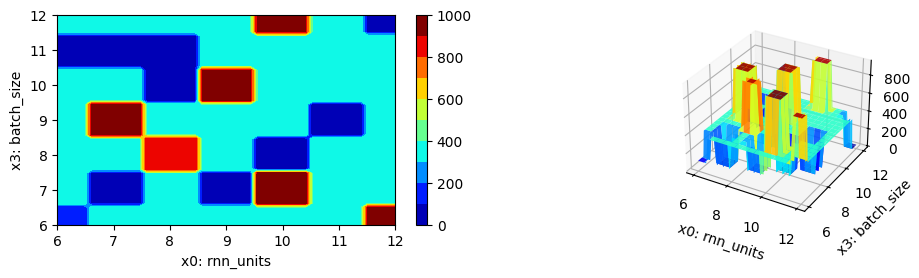

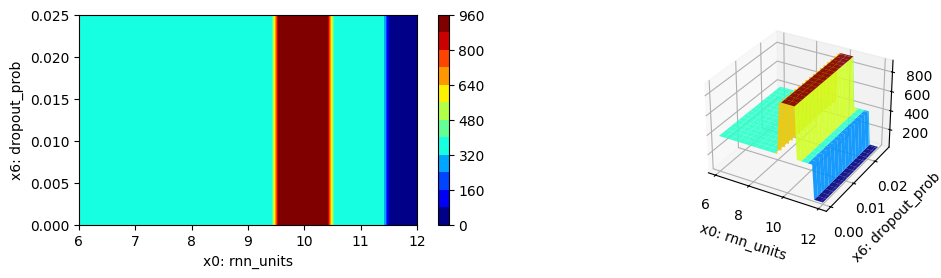

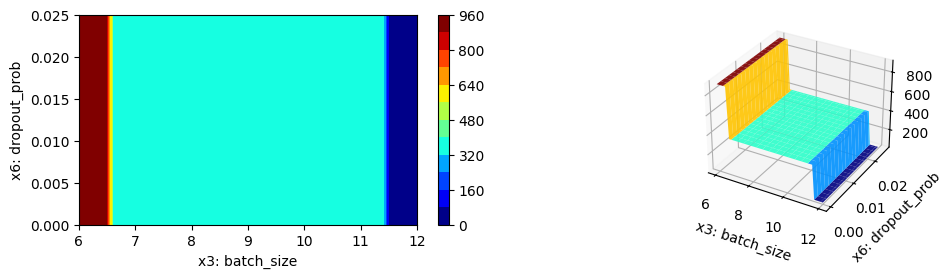

In [12]:
print_res_table(spot_tuner)
spot_tuner.plot_important_hyperparameter_contour(max_imp=3)

In [13]:
len(spot_tuner.y)

46

## Summary

This section showed how to use user-specified data sets for the hyperparameter tuning process with `spotpython`. The user needs to provide the data set and load it as a `spotpython` `CSVDataset()` class.